In [ ]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance.clone().detach())
    population.phenotypes = breeding_values + environmental_noise

#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)

# Function to run one generation
def run_generation(P, T, h2, reps, pop_size, selection_fraction):
    bv(P, T)  # Calculate breeding values
    phenotype(P, T, h2)  # Calculate phenotypes with given h2
    selected = P.haplotypes[torch.topk(P.phenotypes, int(pop_size * selection_fraction)).indices]  # Select top individuals based on phenotype
    m = recombine(selected)  # Mother gametes
    f = recombine(selected)  # Father gametes
    progeny = create_progeny(m, f, reps=reps)  # Create progeny
    new_population = Population(G, progeny)
    bv(new_population, T)  # Calculate breeding values for progeny
    phenotype(new_population, T, h2)  # Calculate phenotypes for progeny
    return new_population

In [ ]:

# Parameters
pop_size = 200
h2 = 0.99
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

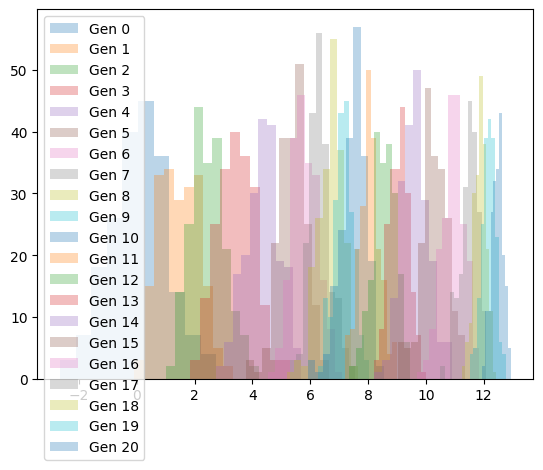

In [ ]:


# Parameters
pop_size = 200
h2 = 0.99
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

# Store populations for plotting
pops = [P]

# Run multiple generations
for generation in range(num_generations):
    P = run_generation(P, T, h2, reps, pop_size, selection_fraction=1/reps)
    pops.append(P)

# Plot phenotypes for each generation
for i, P in enumerate(pops):
    plt.hist(P.phenotypes, alpha=0.3, label=f'Gen {i}')

plt.legend()

plt.show()

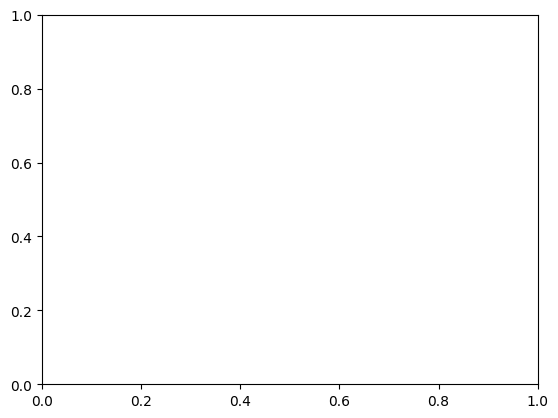

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

# Parameters
pop_size = 200
h2 = 0.3
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

# Store populations for plotting
pops = [P]

# Run multiple generations
for generation in range(num_generations):
    P = run_generation(P, T, h2, reps, pop_size, selection_fraction=1/reps)
    pops.append(P)

# Flatten phenotypes from all generations to find the axis limits
all_phenotypes = torch.cat([P.phenotypes for P in pops])
min_val = all_phenotypes.min().item()
max_val = all_phenotypes.max().item()
bins = torch.linspace(min_val, max_val, 30).numpy()

# Create the figure and axis
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.hist(pops[i].phenotypes.numpy(), bins=bins, alpha=0.3)
    ax.set_title(f'Generation {i}')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(0, pop_size)

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(pops), repeat=False)

# Show the animation
plt.show()


/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


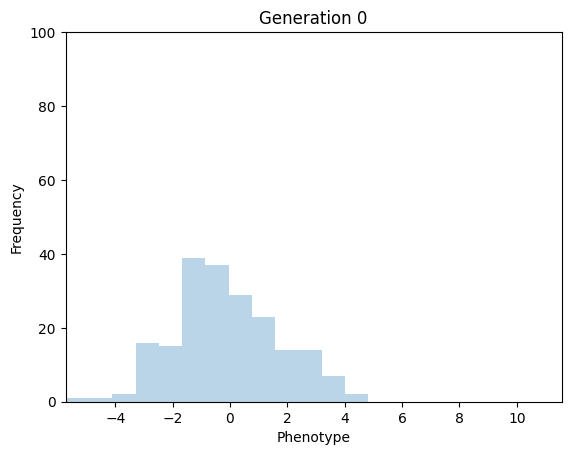

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters
pop_size = 200
h2 = 0.3
reps = 5
num_generations = 50

# Assume the Genome, create_pop, create_random_pop, Trait, run_generation functions are defined elsewhere
# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

# Store populations for plotting
pops = [P]

# Run multiple generations
for generation in range(num_generations):
    P = run_generation(P, T, h2, reps, pop_size, selection_fraction=1/reps)
    pops.append(P)

# Determine the max and min phenotype values for setting consistent axes
all_phenotypes = torch.cat([pop.phenotypes for pop in pops])
max_val = torch.max(all_phenotypes).item()
min_val = torch.min(all_phenotypes).item()

# Create the figure and axis
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.hist(pops[frame].phenotypes.numpy(), alpha=0.3, bins=20, range=(min_val, max_val))
    ax.set_title(f'Generation {frame}')
    ax.set_xlim(min_val, max_val + (max_val*.1))
    ax.set_ylim(0, pop_size // 2)  # Adjust the y-axis limit as needed
    ax.set_xlabel('Phenotype')
    ax.set_ylabel('Frequency')

# Create the animation
ani = FuncAnimation(fig, update, frames=num_generations + 1, repeat=False)

# Display the animation in the notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


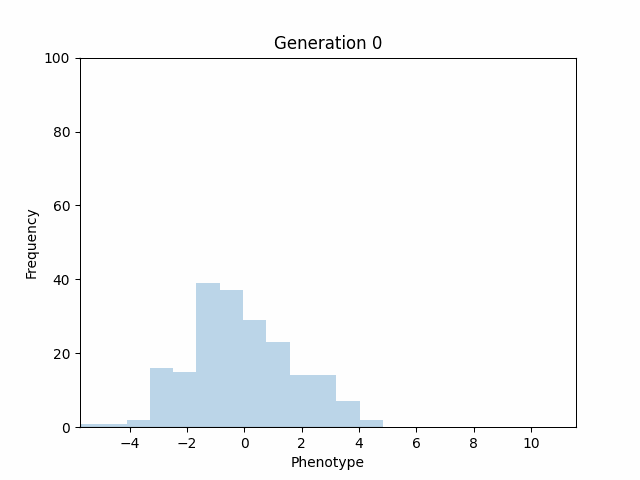

In [ ]:

# Save the animation as a GIF
ani.save('phenotype_animation.gif', writer='pillow')

# Display the animation in the notebook (optional)
from IPython.display import Image
Image(filename='phenotype_animation.gif')

In [ ]:
!pwd

/mnt/c/Users/cltng/OneDrive/chatgpt/nbs
